### Tmapの効率をフィッティングをするコード

#### Step 1 : 必要なパッケージをインストール

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
from scipy.optimize import leastsq, curve_fit, least_squares    # カーブフィッティング用

#### Step 2 : データの読み出し

In [83]:
# Tkinter のルートウィンドウを作成
root = Tk()
root.withdraw()                     # 余分なウィンドウを表示しないようにする
root.attributes("-topmost", True)   # フォルダ選択ダイアログを前面に表示する
# ファイル選択ダイアログを開く
filename = filedialog.askopenfilename(title="ファイルを選択してください",initialdir='./')
# 結果を表示
print("選択されたフォルダ:", filename)

dataT = pd.read_csv(filename)
print(dataT)

選択されたフォルダ: C:/MyStudy/OptimizationStudy/Tmapfitting/Example1.csv
     Unnamed: 0     nATL  Pamb     P1     P2     P3     P4      M1      M2  \
0           1.0  67000.0  97.8  95.14  104.1  128.7  97.83  0.1398  0.1398   
1           2.0  67010.0  97.8  96.17  120.6  126.4  97.83  0.1077  0.1077   
2           3.0  67020.0  97.8  96.71  126.7  124.2  97.82  0.0856  0.0856   
3           4.0  67020.0  97.8  97.12  129.9  121.8  97.80  0.0662  0.0662   
4           5.0  67000.0  97.8  97.36  131.1  119.6  97.76  0.0487  0.0487   
..          ...      ...   ...    ...    ...    ...    ...     ...     ...   
121         NaN      NaN   NaN    NaN    NaN    NaN    NaN     NaN     NaN   
122         NaN      NaN   NaN    NaN    NaN    NaN    NaN     NaN     NaN   
123         NaN      NaN   NaN    NaN    NaN    NaN    NaN     NaN     NaN   
124         NaN      NaN   NaN    NaN    NaN    NaN    NaN     NaN     NaN   
125         NaN      NaN   NaN    NaN    NaN    NaN    NaN     NaN     NaN   

#### Step 3 : 回転数ごとにデータを抽出

In [84]:
# 最大回転数と区切る回転数の分解能設定
# ※ データによって調整すること
Nmax = 150000
dN = 7500
# 初期値の設定
N_length = 0
idx = []
# 回転数ごとにデータを区切る
for i in range(1, Nmax // dN + 1):
    tmp_idx = (dataT['nATL'] >= (i-1)*dN) & (dataT['nATL'] < i*dN)
    if tmp_idx.sum() > 2:
        idx.append(tmp_idx)
        N_length += 1
idx = np.array(idx).T

# 回転数ごとのパラメータを抽出
# 格納用の配列を作成
N = np.zeros(N_length)
eta = np.zeros((idx[:,0].sum(), N_length))
Pit = np.zeros((idx[:,0].sum(), N_length))
BSR = np.zeros((idx[:,0].sum(), N_length))
idx_max = np.zeros(N_length)
eta_max = np.zeros(N_length)
Pit_opt = np.zeros(N_length)
BSR_opt = np.zeros(N_length)
# パラメータを抽出
for i in range(N_length):
    N[i] = dataT['nATL'][idx[:,i]].mean()
    eta[:,i] = dataT['Etamech'][idx[:,i]]
    Pit[:,i] = dataT['PitotT'][idx[:,i]]
    BSR[:,i] = dataT['u/c0'][idx[:,i]]
    eta_max[i] = dataT['Etamech'][idx[:,i]].max()
    idx_max[i] = dataT['Etamech'][idx[:,i]].idxmax()
    Pit_opt[i] = dataT['PitotT'][idx_max[i]]
    BSR_opt[i] = dataT['u/c0'][idx_max[i]]

#### Step 4 : 最大効率とブレード周速比を周速マッハ数でフィッティング

$$
\begin{equation}
    \begin{aligned}
        \eta_{max} & = \alpha_{2} M^2 + \alpha_{1} M + \alpha_{0} \\
        BSR_{opt} & = \beta_{2} M^2 + \beta_{1} M + \beta_{0}
    \end{aligned}
\end{equation}
$$

Optimized alpha: [-0.1363988   0.19952539  0.51566331]
Optimized beta : [0.17095867 0.405437  ]


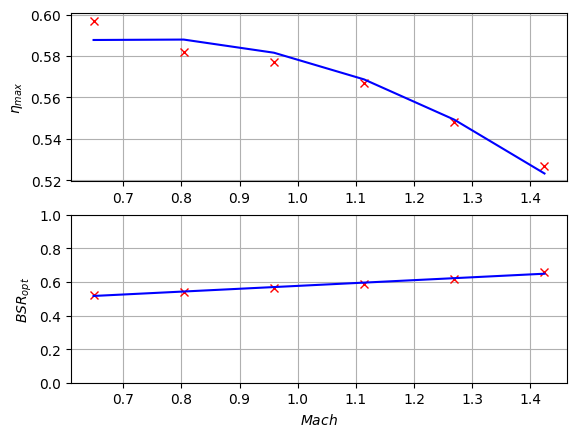

In [85]:
# タービンのパラメータを設定
Dt = 0.062      # m
cp = 1082       # J/K/kg
T = 293.15      # K
R = 288         # J/K/kg
kap = 1.33

# フィッティング関数の定義
def modelFunc_eta_max(prm,x) :
    coeff = prm
    y = (1-coeff[0] * np.exp(coeff[1]*x))* coeff[2] 
    return y

# 多項式の定義式
def fitingCurve_poly(prm,x) :
    coeff = prm
    y = 0
    for i in range(len(coeff)) :
        y += coeff[i] * x ** (len(coeff)-(i+1))
    return y

def objFunc_eta_max(params, x, eta_max):
    return np.sum((eta_max - fitingCurve_poly(params, x))**2)
    #return np.sum((eta_max - modelFunc_eta_max(params, x))**2)

def objFunc_BSR_opt(params, x, BSR_opt):
    return np.sum((BSR_opt - fitingCurve_poly(params, x))**2)


# フィッティング
initial_params = [1, 1, 1]
Mach = Dt * np.pi * N / 60 / np.sqrt(kap * R * T)
opt_params = least_squares(objFunc_eta_max, initial_params, loss='linear', args=(Mach, eta_max))
alpha = opt_params.x

initial_params = [1, 1]
opt_params = least_squares(objFunc_BSR_opt, initial_params, loss='soft_l1', args=(Mach, BSR_opt))
beta = opt_params.x


# フィッティング結果の表示
print(f'Optimized alpha: {alpha}')
print(f'Optimized beta : {beta}')

# Nt と eta_max の関係
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(Mach, eta_max, 'rx')
plt.plot(Mach, fitingCurve_poly(alpha, Mach), 'b-')
plt.ylabel(r'$\eta_{max}$')
plt.grid(True)
# plt.ylim([0, 1])
# Pit_opt と BSR_opt の関係
plt.subplot(2, 1, 2)
plt.plot(Mach, BSR_opt, 'rx')
plt.plot(Mach, fitingCurve_poly(beta, Mach), 'b-')
plt.xlabel(r'$Mach$')
plt.ylabel(r'$BSR_{opt}$')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

#### Step 4 : 効率とブレード周速比を正規化
フィッティングには正規化ブレード周速比と正規化効率を用いる。
- 正規化効率
    $$
        \eta_{norm} = \cfrac{\eta |_{Nt}}{\eta_{max}|_{Nt}}
    $$
- 正規化ブレード周速比
    $$
        {BSR}_{norm} = \cfrac{{BSR} |_{Nt}}{{BSR}_{opt}|_{Nt}}
    $$
ただし，${BSR}_{opt}$ は $\eta_{max}$ の時のブレード周速であり，効率の最大値はタービン回転数 $Nt$ ごとに異なることに注意。

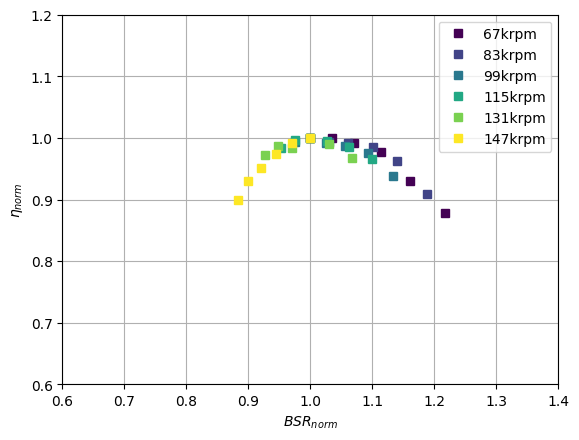

In [86]:
BSR_norm = np.array([])
eta_norm = np.array([])

# プロットの準備
plt.figure()
plt.grid(True)
plt.box(True)
colors = plt.cm.viridis(np.linspace(0, 1, N_length))  # 色の配列を作成

for i in range(N_length):
    # 正規化
    BSR_norm_tmp = BSR[:,i] / BSR_opt[i]
    eta_norm_tmp = eta[:,i] / eta_max[i]
    # 回転数ごとのデータを結合
    BSR_norm = np.concatenate((BSR_norm, BSR_norm_tmp))
    eta_norm = np.concatenate((eta_norm, eta_norm_tmp))
    # 回転数ごとにプロット
    plt.plot(BSR_norm_tmp, eta_norm_tmp, 's', color=colors[i], label=f'{N[i]/1000:.0f}krpm')

# プロット設定
# BSR_norm と eta_norm の関係
plt.legend(loc='upper right')
plt.xlabel(r'$BSR_{norm}$')
plt.ylabel(r'$\eta_{norm}$')
plt.xlim([0.6, 1.4])
plt.ylim([0.6, 1.2])
plt.show()

#### Step4 : 正規化効率と正規化ブレード周速比のフィッティング
フィッティングには以下の関係を用いる。
$$
\begin{equation}
    \begin{aligned}
        \eta_{norm} &= 1 - a \left(1 - {BSR}_{norm}\right)^b &({BSR}_{norm} < 1)\\
        \eta_{norm} &= 1 - c\left({BSR}_{norm} - 1\right)^2 &({BSR}_{norm} \geqq 1)
    \end{aligned}
\end{equation}
$$

In [87]:
# フィッティング関数の定義
def modelFunc_eta_norm(params, x):
    a, b, c = params
    y = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] < 1:
            y[i] = 1 - a * (1 - x[i])**b
        else:
            y[i] = 1 - c * (x[i] - 1)**2
    return y

def objFunc_eta_norm(params, BSR_norm, eta_norm):
    return np.sum((eta_norm - modelFunc_eta_norm(params, BSR_norm))**2)

# フィッティング
initial_params = [1, 2, 1]
opt_params = least_squares(objFunc_eta_norm, initial_params, loss='soft_l1', args=(BSR_norm, eta_norm))
a_opt, b_opt, c_opt = opt_params.x

# フィッティング結果の表示
print(f'Optimized a: {a_opt}')
print(f'Optimized b: {b_opt}')
print(f'Optimized c: {c_opt}')

Optimized a: 2.3108933692366973
Optimized b: 1.5309060219583954
Optimized c: 2.61561683092262


#### Step 6 : フィッティング結果の確認

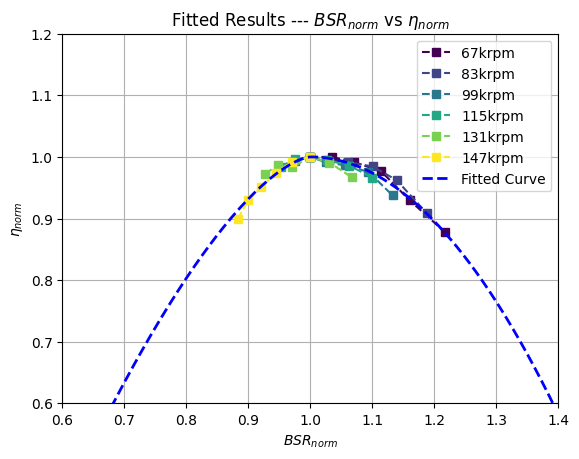

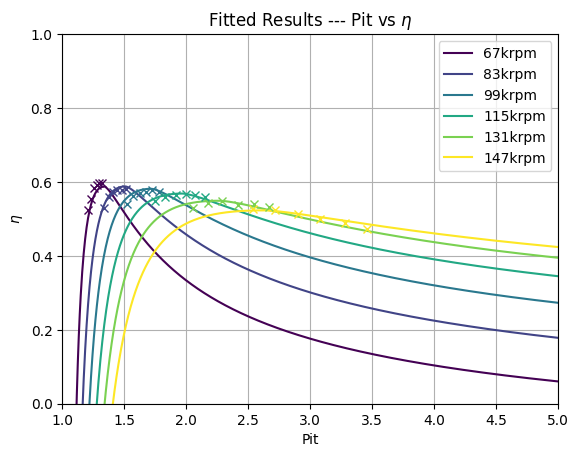

In [88]:
# フィッティンするデータの範囲を定義
# BSR_fit = np.linspace(BSR_norm.min(), BSR_norm.max(), 100)
num_fit = 1000  # フィッティングするデータの数
BSR_fit = np.linspace(0, 2, num_fit)
eta_fit = modelFunc_eta_norm([a_opt, b_opt, c_opt], BSR_fit)

# タービンのパラメータを設定
Dt = 0.062      # m
cp = 1082       # J/K/kg
T = 293.15      # K
kap = 1.33

# フィッティングしたパラメータを用いて、タービンの効率を推定
# 初期値の設定
Pit_est = np.linspace(1.05, 5, num_fit)
BSR_est = np.zeros((num_fit, len(N)))
eta_est = np.zeros((num_fit, len(N)))
eta_max_est = np.zeros((num_fit, len(N)))
BSR_opt_est = np.zeros((num_fit, len(N)))
# 推定
for i in range(len(N)):
    Mach_est = Dt * np.pi * N[i] / 60 / np.sqrt(kap * R * T)
    eta_max_est[:,i] = fitingCurve_poly(alpha, Mach_est)
    BSR_opt_est[:,i] = fitingCurve_poly(beta, Mach_est)
    BSR_est[:,i] = (N[i] * np.pi/60 * Dt/2) / np.sqrt(2 * cp * T * (1 - Pit_est**((1 - kap) / kap)))
    eta_est[:,i] = eta_max_est[:,i] * modelFunc_eta_norm([a_opt, b_opt, c_opt], BSR_est[:,i]/BSR_opt_est[:,i])
    #eta_est[:,i] = eta_max[i] * modelFunc_eta_norm([a_opt, b_opt, c_opt], BSR_est[:,i]/BSR_opt[i])

# プロット
plt.figure()
plt.grid(True)
plt.box(True)
colors = plt.cm.viridis(np.linspace(0, 1, N_length))  # 色の配列を作成
for i in range(N_length):
    plt.plot(BSR[:,i] / BSR_opt[i], eta[:,i] / eta_max[i], 's--', color=colors[i], label=f'{N[i]/1000:.0f}krpm')
plt.plot(BSR_fit, eta_fit, 'b--', linewidth=2, label='Fitted Curve')
plt.xlabel(r'$BSR_{norm}$')
plt.ylabel(r'$\eta_{norm}$')
plt.title('Fitted Results --- $BSR_{norm}$ vs $\eta_{norm}$')
plt.legend(loc='upper right')
plt.xlim([0.6, 1.4])
plt.ylim([0.6, 1.2])
plt.show()

plt.figure()
plt.grid(True)
plt.box(True)
for i in range(N_length):
    plt.plot(Pit_est, eta_est[:,i], color=colors[i], label=f'{N[i]/1000:.0f}krpm')
for i in range(N_length):
    plt.plot(Pit[:,i], eta[:,i], 'x', color=colors[i])
plt.xlabel(r'Pit')
plt.ylabel(r'$\eta$')
plt.title('Fitted Results --- Pit vs $\eta$')
plt.legend(loc='upper right')
plt.xlim([1, 5])
plt.ylim([0, 1])
plt.show()